In [2]:
import pandas as pd
import numpy as np
import os
import json

In [3]:
from glob import glob

model_path = glob('/directory/Anomaly_Transformer/saved_models/*')
 
df = pd.DataFrame()

for j in range(len(model_path)):

    test_metrics_path = glob(os.path.join(model_path[j],'*','best_test_result.json'))

    metric_df = pd.DataFrame()

    for i in range(len(test_metrics_path)):
        dir = test_metrics_path[i]
        # Open the JSON file
        with open(dir, 'r') as f:
            data = json.load(f)

        dataset_name = dir.split('/')[-3]
        f_1 = data['eval_metrics']['test_f1_score']
        recall = data['eval_metrics']['test_recall']
        precision = data['eval_metrics']['test_recall']
        use_pa = dir.split('/')[-2][:7]
        seed = dir.split('/')[-2].split('_')[-1]

        temp = pd.DataFrame([dataset_name, use_pa,seed,precision,recall,f_1]).T

        metric_df = pd.concat([metric_df, temp], axis = 0)

    df = pd.concat([df, metric_df])

df.columns = ['Dataset', 'PA', 'SEED',' Precision', 'Recall', 'F1-Score']
df.reset_index(drop = True, inplace = True)

In [4]:
df

,Dataset,PA,SEED,Precision,Recall,F1-Score
0,MSL,with_PA,1998,0.975921,0.975921,0.947553
1,MSL,without,1105,0.010945,0.010945,0.019993
2,MSL,without,1905,0.01146,0.01146,0.020934
3,MSL,without,1998,0.010945,0.010945,0.019993
4,MSL,with_PA,1905,0.970255,0.970255,0.944887
5,MSL,with_PA,1105,0.955447,0.955447,0.937105
6,SMAP,with_PA,1998,0.996343,0.996343,0.965206
7,SMAP,without,1105,0.011226,0.011226,0.020823
8,SMAP,without,1905,0.01022,0.01022,0.018958
9,SMAP,without,1998,0.010677,0.010677,0.019806


In [5]:
df.drop(columns = 'SEED').groupby(['Dataset','PA']).mean()

Precision    Recall  F1-Score
Dataset PA                                     
MSL     with_PA    0.967207  0.967207  0.943182
        without    0.011117  0.011117  0.020307
SMAP    with_PA    0.996465  0.996465  0.965307
        without    0.010708  0.010708  0.019863
SMD     with_PA    0.950154  0.950154  0.923827
        without    0.013483  0.013483  0.024071

## MSL Case Analysis

In [6]:
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

plt.style.use('ggplot')

In [7]:
def graph_longest_segment(dirs):

    thresh_dir, anomaly_score_dir, gt_dir, pred_dir = dirs
    
    dir = thresh_dir[3]
    dataset_name = dir.split('/')[-3]

    # Open the JSON file
    with open(dir, 'r') as f:
        data = json.load(f)
        
    threshold = data['threshold']

    anomaly_score = np.load(anomaly_score_dir[3])
    gt = np.load(gt_dir[3])
    pred = np.load(pred_dir[3])

    precision, recall, f_1, _ = precision_recall_fscore_support(gt, pred, average='binary')

    print(f'Precision: {precision: .4f}, Recall: {recall: .4f}, F1-Score: {f_1: .4f}', end = '\n\n')

    print(f'prediction shape: {pred.shape}, ground truth shape: {gt.shape}, anomaly score shape: {anomaly_score.shape}', end = '\n\n')

    anomaly_index = []
    anomaly_state = False
    temp = []
    for i in range(len(gt)):
        if gt[i] == 1:
            anomaly_state = True
            temp.append(i)

        elif gt[i] == 0 and anomaly_state:
            anomaly_state = False
            anomaly_index.append(temp)
            temp = []

    anomaly_length = [len(x) for x in anomaly_index]

    print(f'Maximum Anomaly Segment Length for {dataset_name} dataset is {max(anomaly_length)} ', end = '\n\n')

    correct = (pred[anomaly_index[anomaly_length.index(max(anomaly_length))]]==1).sum()

    print(f'Corrected detected {correct} points out of {max(anomaly_length)}', end = '\n\n')

    segment = anomaly_score[anomaly_index[anomaly_length.index(max(anomaly_length))]]

    plt.figure(figsize = (15,5))
    plt.plot(segment, label = 'Anomaly Score')

    plt.axhline(threshold, lw = 0.5, color = 'Blue', label = f'Threshold: {threshold:.4f}')
    plt.ylim(bottom = 0, top = 1.0)
    plt.title('{} Longest Anomalous Segment Example (Extreme Value Truncated)'.format(dataset_name), size = 10)

    plt.legend()
    plt.show()

In [8]:
model_path

['/directory/Anomaly_Transformer/saved_models/MSL',
 '/directory/Anomaly_Transformer/saved_models/SMAP',
 '/directory/Anomaly_Transformer/saved_models/SMD']

Precision:  0.1153, Recall:  0.0109, F1-Score:  0.0200

prediction shape: (73700,), ground truth shape: (73700,), anomaly score shape: (73700,)

Maximum Anomaly Segment Length for MSL dataset is 1141 

Corrected detected 12 points out of 1141



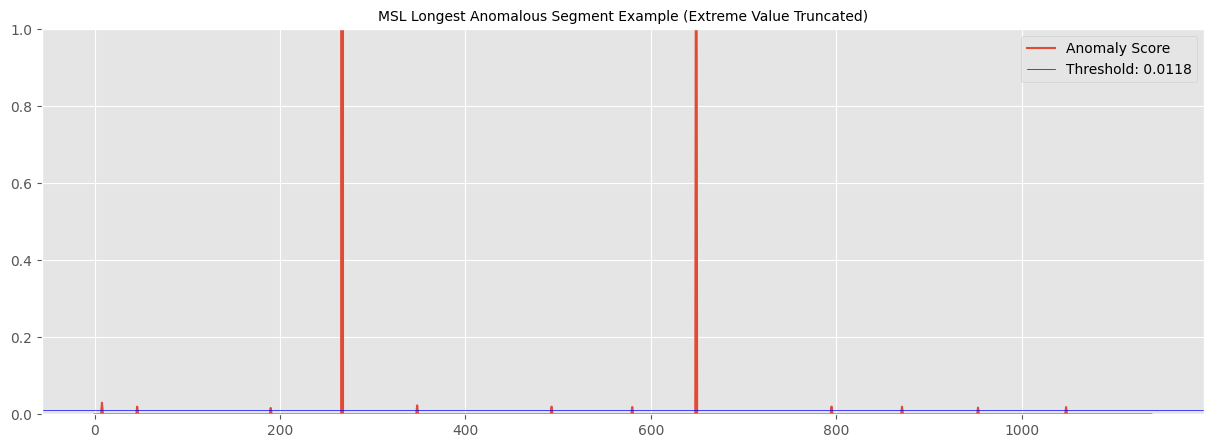

Precision:  0.1436, Recall:  0.0112, F1-Score:  0.0208

prediction shape: (427600,), ground truth shape: (427600,), anomaly score shape: (427600,)

Maximum Anomaly Segment Length for SMAP dataset is 4218 

Corrected detected 45 points out of 4218



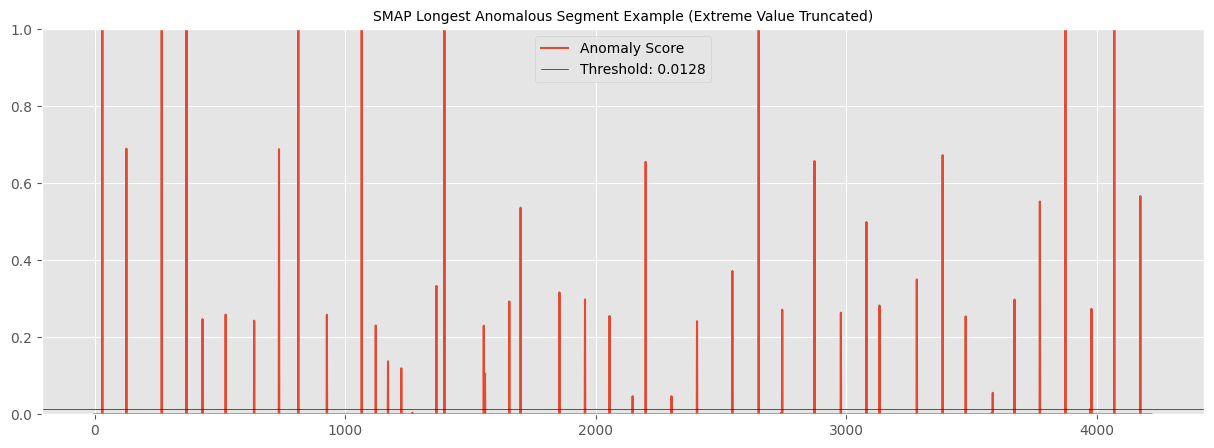

Precision:  0.1084, Recall:  0.0130, F1-Score:  0.0233

prediction shape: (708400,), ground truth shape: (708400,), anomaly score shape: (708400,)

Maximum Anomaly Segment Length for SMD dataset is 3161 

Corrected detected 33 points out of 3161



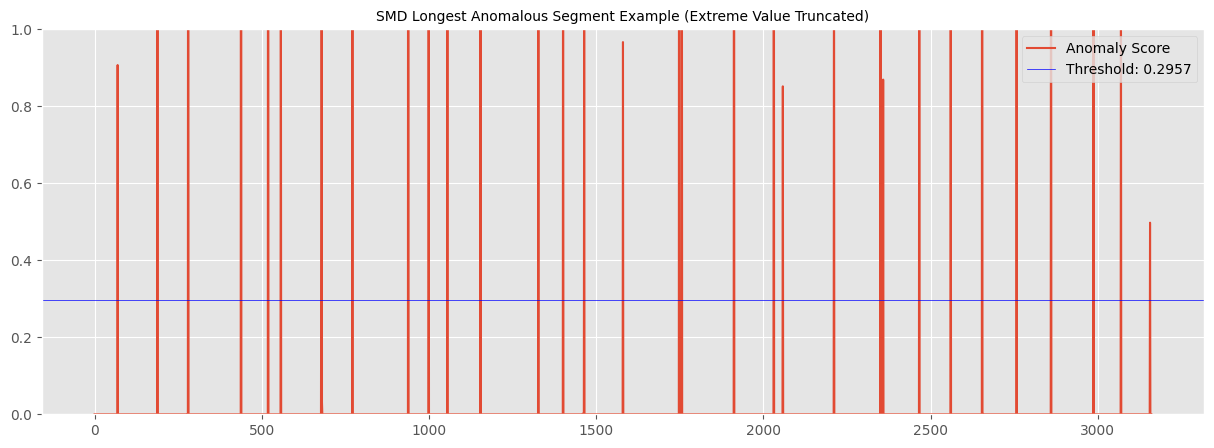

In [9]:
for i in range(len(model_path)):
    
    thresh_dir = sorted(glob(os.path.join(model_path[i],'*','best_test_result.json')))
    anomaly_score_dir = sorted(glob(os.path.join(model_path[i],'*','anomaly_score.npy')))
    gt_dir = sorted(glob(os.path.join(model_path[i],'*','gt.npy')))
    pred_dir = sorted(glob(os.path.join(model_path[i],'*','pred.npy')))

    graph_longest_segment((thresh_dir, anomaly_score_dir, gt_dir, pred_dir))

In [15]:
length = len(np.load(pred_dir[3]))

In [71]:
gt = np.load(gt_dir[3])

gt_dir[3]

'/directory/Anomaly_Transformer/saved_models/SMD/without_PA_1105/gt.npy'

In [70]:
import random

random.seed(1998)

random_sample = np.random.randn(length,)

thresh = np.percentile(random_sample, 100 - 1.0)

pred_random = (random_sample>thresh).astype(int)
_, _, f1, _= precision_recall_fscore_support(gt, pred_random, average='binary')

f1

0.01598773543583005

In [66]:
for ratio in np.arange(0.5, 2.1, 0.1):

    random_sample = np.random.randn(length,)

    thresh = np.percentile(random_sample, 100 - ratio)

    pred_random = (random_sample>thresh).astype(int)

    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred_random[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0, -1):
                if gt[j] == 0:
                    break
                else:
                    if pred_random[j] == 0:
                        pred_random[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred_random[j] == 0:
                        pred_random[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred_random[i] = 1
    _, _, f1, _= precision_recall_fscore_support(gt, pred_random, average='binary')

    print(f"Anomaly_ratio : {ratio} & f1: {f1:.4f}")

Anomaly_ratio : 0.5 & f1: 0.7667
Anomaly_ratio : 0.6 & f1: 0.8196
Anomaly_ratio : 0.7 & f1: 0.8269
Anomaly_ratio : 0.7999999999999999 & f1: 0.7868
Anomaly_ratio : 0.8999999999999999 & f1: 0.8269
Anomaly_ratio : 0.9999999999999999 & f1: 0.8252
Anomaly_ratio : 1.0999999999999999 & f1: 0.8235
Anomaly_ratio : 1.1999999999999997 & f1: 0.8009
Anomaly_ratio : 1.2999999999999998 & f1: 0.8012
Anomaly_ratio : 1.4 & f1: 0.8051
Anomaly_ratio : 1.4999999999999998 & f1: 0.8048
Anomaly_ratio : 1.5999999999999996 & f1: 0.7880
Anomaly_ratio : 1.6999999999999997 & f1: 0.7914
Anomaly_ratio : 1.7999999999999998 & f1: 0.7766
Anomaly_ratio : 1.8999999999999997 & f1: 0.7685
Anomaly_ratio : 1.9999999999999996 & f1: 0.7752


In [58]:
f1

0.8294483881253251